In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import pickle

In [3]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.
train_df = pd.read_csv("KDDTrain+_2.csv", header=None, names = col_names)
test_df = pd.read_csv("KDDTest+_2.csv", header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',train_df.shape)
print('Dimensions of the Test set:',test_df.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [4]:
train_df.head()    

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
print(train_df.columns)


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')


In [6]:
for df in [train_df, test_df]:
    df['label'] = df['label'].str.strip().str.lower()
    df['label'] = df['label'].apply(
        lambda x: 'Benign' if x == 'normal' else 'Malicious'
    )

train_df['label'].value_counts()

label
Benign       67343
Malicious    58630
Name: count, dtype: int64

In [7]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

X_test  = test_df.drop('label', axis=1)
y_test  = test_df['label']


In [8]:
cat_cols = ['protocol_type', 'service', 'flag']

encoder = LabelEncoder()
for col in cat_cols:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col]  = encoder.transform(X_test[col])


In [9]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test  = X_test.apply(pd.to_numeric, errors='coerce')

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(
    X_train_scaled, y_train
)
pd.Series(y_train_res).value_counts()

label
Benign       67343
Malicious    67343
Name: count, dtype: int64

In [12]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res, y_train_res)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [13]:
feature_importance = dt.feature_importances_

importance_df = pd.DataFrame({
    'Feature Index': range(len(feature_importance)),
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)

,Feature Index,Importance
4,4,0.753645
1,1,0.071415
32,32,0.047578
9,9,0.024068
40,40,0.023967
5,5,0.022447
2,2,0.010451
11,11,0.009316
35,35,0.008200
33,33,0.006256


In [14]:
y_pred = dt.predict(X_test_scaled)

In [15]:
y_pred

array(['Malicious', 'Malicious', 'Benign', ..., 'Malicious', 'Benign',
       'Malicious'], shape=(22544,), dtype=object)

In [16]:
print("Accuracy: ",accuracy_score(y_test, y_pred))
print("\nClassification Report: \n")
print(classification_report(y_test, y_pred))

Accuracy:  0.7931156848828956

Classification Report: 

              precision    recall  f1-score   support

      Benign       0.68      0.97      0.80      9711
   Malicious       0.97      0.66      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.83      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = dt.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[9428  283]
 [4381 8452]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.68      0.97      0.80      9711
   Malicious       0.97      0.66      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.83      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



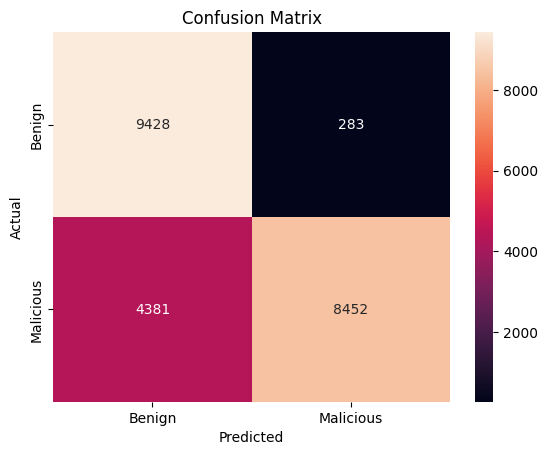

In [18]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm , annot= True, fmt='d', xticklabels=['Benign','Malicious'],
            yticklabels=['Benign', 'Malicious'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
pickle.dump(dt, open("ids_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = dt.predict(X_test_scaled)

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, pos_label="Malicious"),
    "recall": recall_score(y_test, y_pred, pos_label="Malicious"),
    "f1": f1_score(y_test, y_pred, pos_label="Malicious"),
    "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
}

with open("metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)
print(dt.classes_)

['Benign' 'Malicious']


## Conclusion

In this project, a machine learning based intrusion detection system was developed to classify network traffic as benign or malicious. The Decision Tree classifier achieved good accuracy and demonstrated the effectiveness of machine learning techniques in cybersecurity applications.


“Yes sir/ma’am. The project implements a machine-learning-based intrusion detection system that classifies network traffic as benign or malicious using NSL-KDD data, with proper preprocessing, training, evaluation, and analysis.”